## Kaggle Competition Report - Fall 2023 Data Mining

In [1]:
##Imports 
import json 
import pandas as pd
import csv
import numpy as np
import emoji
import re

## 1. Data Preparation and Exploration

#### 1.1 Loading the raw tweets_DM.json file

We aim to create both a training and testing dataframe from the tweets_DM.json file. First let's load the raw tweet data into a python list and explore the possible attributes to consider:

In [2]:
##Opening the tweets_DM.json file
tweet_data = [];
with open("./data/tweets_DM.json" ,'r') as file:
    for line in file:   
        tweet_data.append(json.loads(line));

In [3]:
tweet_data[0]

{'_score': 391,
 '_index': 'hashtag_tweets',
 '_source': {'tweet': {'hashtags': ['Snapchat'],
   'tweet_id': '0x376b20',
   'text': 'People who post "add me on #Snapchat" must be dehydrated. Cuz man.... that\'s <LH>'}},
 '_crawldate': '2015-05-23 11:42:47',
 '_type': 'tweets'}

Let's check the length of the tweet_data list:

In [4]:
len(tweet_data)

1867535

#### 1.2 Creating the testing and training datasets

Our first big goal is to create a dataframe. We first systematically extract the relevant data from the .json file and we aim to create a .csv file for training and testing datasets simultaneously. We have identified the following attributes as relevant for our model. 
<ul>
    <li>tweet_id </li>
    <li>tweet_text</li>
    <li>score</li>
    <li>crawl_date</li>
    <li>hashtag_text</li>
    <li>target emotion (From emotion.csv)</li>
</ul>

We will read the *data_identification.csv* file and use the *identification* attribute to control where each data entry in the tweets_data list is directed to (either testing or training datasets). First, let's determine if any keys in the provided tweets json file have missing values. We design the feature counter for this purpose. While not too relevant right now, it may help us improve our data extraction procedures.

In [5]:
def feature_counter(tweet_data):
    ##Get the keys 
    keys = tweet_data[0].keys()
    
    ##Count the features 
    feature_counts = dict.fromkeys(keys,0);
    for tweet in tweet_data:
        for key in keys:
            if tweet[key]:
                feature_counts[key] += 1;
    return feature_counts;

In [6]:
feature_counts = feature_counter(tweet_data);
feature_counts

{'_score': 1867535,
 '_index': 1867535,
 '_source': 1867535,
 '_crawldate': 1867535,
 '_type': 1867535}

Therefore, each of the attributes above has some data in it. We are particulary interested in the source data since it contains the *tweet_id* and *tweet_text* attributes. These attributes are the cornerstone to improve the performance of our future model. 

In [7]:
###Generate dictionary with featurest of interest
def gen_tweet_dict(tweet_data):
    ##Get the keys 
    keys = tweet_data[0].keys()
    source_keys = tweet_data[0]["_source"]["tweet"].keys(); #['hashtags', 'tweet_id', 'text']

    ##Declare temp variables to hold tweet_id, tweet_text, score, crawl_date, hashtag_text
    tweet_id_key = ''; #String 
    tweet_text = '';   #String
    score = 0;         #int
    crawl_date = '';   #string"
    hashtag_text = ''; #List but cast it to string 
    hashtag = list();
    
    ##Create a dictionary with tweet_id as keys 
    tweet_dict = dict();

    ##Fill the dictionary
    for tweet in tweet_data:
        for key in keys:
            if key == "_index" or key == "_type":
                continue;
            else: 
                if key == "_score":
                    score = np.int16(tweet[key]);
                elif key == "_crawldate":
                    crawl_date = tweet[key];    
                elif key == "_source":
                    for skey in source_keys:
                        if skey == "hashtags":
                            hashtag = tweet[key]["tweet"][skey];
                            if len(hashtag) > 0: ##Tweet has hashtags
                                hashtag_text = ' '.join(hashtag)
                            else:
                                hashtag_text = ' ';
                        elif skey == "tweet_id":
                            tweet_id_key = tweet[key]["tweet"][skey];
                            tweet_dict[tweet_id_key] = {'tweet_id': tweet_id_key}
                        elif skey == "text":
                            tweet_text = str(tweet[key]["tweet"][skey])
                            tweet_text = tweet_text.replace('\r', "")
        
        ##Merge dictionaries
        tweet_dict[tweet_id_key] |= {"score" : score, "crawl_date" : crawl_date, "hashtag_text": hashtag_text, "tweet_text":tweet_text};   
    
        ##Reset values
        tweet_id_key = ''; tweet_text = ''; score = 0; crawl_date = ''; hashtag_text = ''; hashtag = list();

    return tweet_dict;                      

In [8]:
tweet_dict = gen_tweet_dict(tweet_data);

Let's check some values in our dictionary and verify they are the same as in the tweets JSON file:

In [9]:
tweet_dict['0x3376ab']

{'tweet_id': '0x3376ab',
 'score': 491,
 'crawl_date': '2016-12-25 02:16:36',
 'hashtag_text': ' ',
 'tweet_text': 'AND this British guy just paid for our dinner. Im feeling super <LH> rn'}

In [10]:
tweet_dict['0x2e4bae'] ##Carriage return \r example removed

{'tweet_id': '0x2e4bae',
 'score': 696,
 'crawl_date': '2016-08-18 13:43:49',
 'hashtag_text': 'beautiful shahidkapoor Mirah',
 'tweet_text': 'MIRAH RAJPUT is so luckyyyy!pretty pretty beauty beauty.#beautiful #shahidkapoor #Mirah'}

In [11]:
len(list(tweet_dict.keys()))

1867535

Next, we must write to the *train.csv* amd *test.csv* files we created. We use the *data_identification.csv* file entries to determine where to write each dictionary in *tweet_dict*, specificially, each *tweet_id* entry in the *data_identification.csv* is used as key to index the *tweet_dict* dictionary and write to the appropriate csv file. 

In [12]:
def CSV_writer(tweet_dict):
    ##First open the relevant csv files either in reading or writing mode
    #Open the data_identification.csv in reading mode:
    dataID_file = open("./data/data_identification.csv", 'r');
    dataID_reader = csv.reader(dataID_file);
    next(dataID_reader); #['tweet_id', 'identification'] 

    #Open the train.csv and test.csv in writing mode
    train_file = open("./train.csv", 'w', newline='');
    train_writer = csv.writer(train_file);
    test_file  = open("./test.csv", 'w', newline=''); 
    test_writer = csv.writer(test_file);

    #Counter for each type of entry. We later verify that the sum of the counters is equal to the total number of examples
    train_count = 0;
    test_count  = 0;
    data_count =  0;

    ##Write the header to each file 
    header = ['tweet_id','tweet_text','hashtag_text','crawl_date','score'];
    train_writer.writerow(header);
    test_writer.writerow(header);

    ##Write each dictionary entry into either train.csv or test.csv
    keys = ['tweet_id','tweet_text','hashtag_text','crawl_date','score'];
    for row in dataID_reader:
        key = str(row[0]);
        target_csv = str(row[1]);
        tweet = tweet_dict[key]; 

        data = [];
        for k in keys:
            data.append(tweet[k]);

        if target_csv == 'train':
            train_writer.writerow(data);
            train_count += 1;
        elif target_csv == 'test':
            test_writer.writerow(data);
            test_count += 1;
    
    print("Processed " + str(train_count) + " training examples ");
    print("Processed " + str(test_count)  + " test examples ")
    print("Processed " + str(train_count+test_count) + " total examples")
    ##Close the files
    dataID_file.close();
    train_file.close();
    test_file.close();


In [13]:
CSV_writer(tweet_dict);

Processed 1455563 training examples 
Processed 411972 test examples 
Processed 1867535 total examples


Now we proceed to create our dataframes from the CSV files as we did in the Lab 2 tutorial. We first create the training dataframe:

In [14]:
### Training data dataframe
train_df = pd.read_csv("./train.csv",header=None, names=['tweet_id','tweet_text','hashtag_text','crawl_date','score'])
train_df.drop([0], inplace = True); #Drop the header

/var/folders/qf/_jd53fqs7hn9l98yc6xmfh040000gn/T/ipykernel_96340/4049140103.py:2: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df = pd.read_csv("./train.csv",header=None, names=['tweet_id','tweet_text','hashtag_text','crawl_date','score'])


In [15]:
train_df.head()

,tweet_id,tweet_text,hashtag_text,crawl_date,score
1,0x29e452,Huge Respect🖒 @JohnnyVegasReal talking about l...,,2015-01-17 03:07:03,809
2,0x2b3819,Yoooo we hit all our monthly goals with the ne...,spateradio app,2016-07-02 09:34:06,808
3,0x2a2acc,@KIDSNTS @PICU_BCH @uhbcomms @BWCHBoss Well do...,,2016-08-15 18:18:39,16
4,0x2a8830,Come join @ambushman27 on #PUBG while he striv...,PUBG GamersUnite twitch BeHealthy StayPositive...,2017-02-11 08:49:46,768
5,0x20b21d,@fanshixieen2014 Blessings!My #strength little...,strength bones God,2016-11-23 05:37:10,70


Let's check the length of the training dataframe:

In [16]:
train_df.shape

(1455563, 5)

Next, let's check the memory usage of the training dataframe and the datatypes of each attribute:

In [17]:
train_df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1455563 entries, 1 to 1455563
Data columns (total 5 columns):
 #   Column        Non-Null Count    Dtype 
---  ------        --------------    ----- 
 0   tweet_id      1455563 non-null  object
 1   tweet_text    1455563 non-null  object
 2   hashtag_text  1455559 non-null  object
 3   crawl_date    1455563 non-null  object
 4   score         1455563 non-null  object
dtypes: object(5)
memory usage: 632.2 MB


The training dataframe is missing the *target_emotion* column which is crucial for our model to learn the emotion corresponding to each tweet. We then create a separate dataframe from the *emotion.csv* file and merge it to our training dataframe on the *tweet_id* column:  

In [18]:
emotion_df = pd.read_csv("./data/emotion.csv",header=None, names=['tweet_id','target_emotion']);
emotion_df.drop([0], inplace = True);
emotion_df.head(10)

,tweet_id,target_emotion
1,0x3140b1,sadness
2,0x368b73,disgust
3,0x296183,anticipation
4,0x2bd6e1,joy
5,0x2ee1dd,anticipation
6,0x34cd80,joy
7,0x33f099,sadness
8,0x2ae7b7,sadness
9,0x2408d4,trust
10,0x2b193b,sadness


Next, as with the training dataframe, let's check the length and memory usage of the emotion dataframe:

In [19]:
emotion_df.shape

(1455563, 2)

In [20]:
emotion_df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1455563 entries, 1 to 1455563
Data columns (total 2 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   tweet_id        1455563 non-null  object
 1   target_emotion  1455563 non-null  object
dtypes: object(2)
memory usage: 177.7 MB


The *memory usage* parameter set to *deep*, provides a better approximation of the memory usage of the system. Since the memory usage of our combined dataframes does not even reach 1 GB, we don't need to perform any memory reduction techniques. We proceed to merge our dataframes on the tweet_id column as follows: 

First, let's cast the *tweet_id* column of each dataframe to string, reset the indices and sort the values in ascending order to make sure both columns have exactly the same values:

In [21]:
##Casting each column to string
emotion_df['tweet_id'] = emotion_df['tweet_id'].astype('string')
train_df['tweet_id'] = train_df['tweet_id'].astype('string')
train_df['tweet_text'] = train_df['tweet_text'].astype('string')

##Sorting and resetting the indices
emotion_df = emotion_df.sort_values(by = ["tweet_id"]);
emotion_df = emotion_df.reset_index(drop = True)

train_df = train_df.sort_values(by = ["tweet_id"]);
train_df = train_df.reset_index(drop = True)

In [22]:
train_df.head(5)

,tweet_id,tweet_text,hashtag_text,crawl_date,score
0,0x1c7f10,o m g Shut Up And Dance though #BlackMirror <LH>,BlackMirror,2015-05-16 10:36:47,242
1,0x1c7f11,On #twitch <LH> on the #Destinybeta #Destiny #...,twitch Destinybeta Destiny Destiny2 Destinythe...,2016-10-15 20:46:37,915
2,0x1c7f14,A nice sunny wak this morning not many <LH> ar...,,2016-07-04 07:22:56,939
3,0x1c7f15,I'm one of those people who love candy corn......,Confession NationalCandyCornDay CouldEatThemAl...,2016-04-16 12:53:40,181
4,0x1c7f16,@metmuseum What are these? They look like some...,,2017-04-22 17:50:28,970


In [23]:
emotion_df.head(5)

,tweet_id,target_emotion
0,0x1c7f10,joy
1,0x1c7f11,anticipation
2,0x1c7f14,joy
3,0x1c7f15,joy
4,0x1c7f16,disgust


Let's check if both columns are the same:

In [24]:
print(train_df['tweet_id'].equals(emotion_df['tweet_id']))

True


Now, let's merge both dataframes into a single training dataframe:

In [25]:
train_df = train_df.merge(emotion_df, on = 'tweet_id', how = 'left')
train_df.head(10)

,tweet_id,tweet_text,hashtag_text,crawl_date,score,target_emotion
0,0x1c7f10,o m g Shut Up And Dance though #BlackMirror <LH>,BlackMirror,2015-05-16 10:36:47,242,joy
1,0x1c7f11,On #twitch <LH> on the #Destinybeta #Destiny #...,twitch Destinybeta Destiny Destiny2 Destinythe...,2016-10-15 20:46:37,915,anticipation
2,0x1c7f14,A nice sunny wak this morning not many <LH> ar...,,2016-07-04 07:22:56,939,joy
3,0x1c7f15,I'm one of those people who love candy corn......,Confession NationalCandyCornDay CouldEatThemAl...,2016-04-16 12:53:40,181,joy
4,0x1c7f16,@metmuseum What are these? They look like some...,,2017-04-22 17:50:28,970,disgust
5,0x1c7f19,Postive thinking is the only way to go followe...,LawOfAttraction ask receive dreambig,2017-08-19 23:08:46,678,anticipation
6,0x1c7f1a,Best Check I’ve had this year <LH> 👀🙏🙏,,2015-10-08 03:43:33,314,joy
7,0x1c7f1b,Have not eaten since yesterday <LH>,,2017-06-06 17:38:13,232,anticipation
8,0x1c7f1c,Glad to know that Ahmedabad has been declared ...,World,2015-03-02 22:19:51,870,trust
9,0x1c7f1d,"John 15:9 As the Father has loved me, so have ...",scriptureverse,2015-11-05 07:59:02,522,joy


In [26]:
##Check the memory usage of the new train df
train_df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1455563 entries, 0 to 1455562
Data columns (total 6 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   tweet_id        1455563 non-null  string
 1   tweet_text      1455563 non-null  string
 2   hashtag_text    1455559 non-null  object
 3   crawl_date      1455563 non-null  object
 4   score           1455563 non-null  object
 5   target_emotion  1455563 non-null  object
dtypes: object(4), string(2)
memory usage: 719.6 MB


#### 1.3 Exploratory Data Analysis

As in Lab #2, let's check how balanced are the classes in the emotion dataframe:

In [27]:
emotion_df.groupby(['target_emotion']).count()['tweet_id']

target_emotion
anger            39867
anticipation    248935
disgust         139101
fear             63999
joy             516017
sadness         193437
surprise         48729
trust           205478
Name: tweet_id, dtype: int64

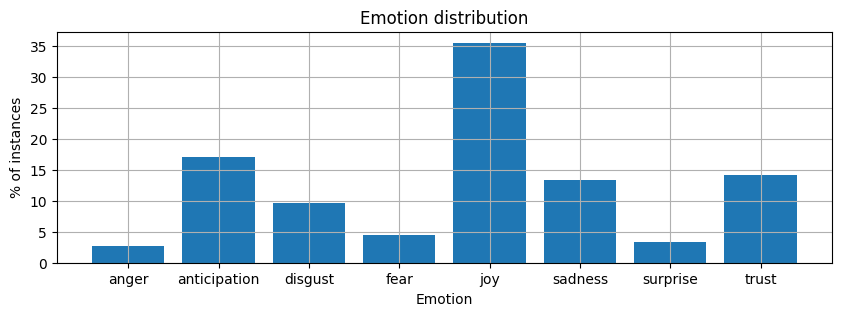

In [28]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# the histogram of the data
labels = emotion_df['target_emotion'].unique()
post_total = len(emotion_df)
df1 = emotion_df.groupby(['target_emotion']).count()['tweet_id']
df1 = df1.apply(lambda x: round(x*100/post_total,3))

#plot
fig, ax = plt.subplots(figsize=(10,3))
plt.bar(df1.index,df1.values)

#arrange
plt.ylabel('% of instances')
plt.xlabel('Emotion')
plt.title('Emotion distribution')
plt.grid(True)
plt.show()

The tweets seem to be biased towards joyful feelings. This is great in the sense that our dataset is dominated by positive feelings but bad for our model since the classes are quite unbalanced. We will sample our dataset to have a more balanced number of examples and use this reduced training dataset to train our model. We first shuffle our dataset and then sample it accordingly:

In [29]:
##Let's shuffle the dataset first
train_df = train_df.sample(frac=1)
train_df.head()

,tweet_id,tweet_text,hashtag_text,crawl_date,score,target_emotion
461576,0x258855,@ewnreporter Highly favoured by God...#blessed...,,2015-05-01 14:10:17,856,joy
800903,0x2c2e95,"I hated school, but I miss it now. <LH>",,2017-02-08 14:26:27,845,joy
311642,0x2298d1,@NARAL @SenSchumer <LH> on the #GOP for being ...,GOP,2015-11-15 13:09:35,283,disgust
21075,0x1ce918,@Uber no one has still gotten back to me over ...,neglect badcustomerservice,2015-10-05 13:15:38,351,disgust
264842,0x21ae69,@CNN <LH> For real sad. This is why we need to...,,2015-11-26 07:02:41,971,sadness


In [30]:
### Now let's sample out train dataset with n = 39867 since it is the minimum number of examples found in one of the classes (anger). 
rtrain_df = train_df.groupby("target_emotion").sample(n=60000, random_state=42, replace=True)

In [31]:
rtrain_df.shape

(480000, 6)

In [32]:
rtrain_df.groupby(['target_emotion']).count()['tweet_id']

target_emotion
anger           60000
anticipation    60000
disgust         60000
fear            60000
joy             60000
sadness         60000
surprise        60000
trust           60000
Name: tweet_id, dtype: int64

Now, our classes are more balanced. Then, we notice that some of the hashtag text columns entries are empty. Since they contain valuable information, we don't want to drop them. Instead, we could add them to the *tweet_text* column and then drop the *hashtag_text* column.  

In [33]:
###First cast the hashtag text column as string
rtrain_df['hashtag_text'] = rtrain_df['hashtag_text']

In [34]:
###Next, we add the hashtag_text to the tweet_text column 
rtrain_df['tweet_text'] = rtrain_df['tweet_text'] + rtrain_df['hashtag_text']
rtrain_df['tweet_text'] = rtrain_df['tweet_text'].astype('string')

In [35]:
###Finally, drop the hashtag_text column
rtrain_df.drop('hashtag_text', axis=1, inplace=True)

In [36]:
rtrain_df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Index: 480000 entries, 227758 to 796533
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   tweet_id        480000 non-null  string
 1   tweet_text      479999 non-null  string
 2   crawl_date      480000 non-null  object
 3   score           480000 non-null  object
 4   target_emotion  480000 non-null  object
dtypes: object(3), string(2)
memory usage: 217.0 MB


Next, the *tweet_text* column has some symbols such as '#','@' or '< LH >'. We want to remove them as they are irrelevant. We preprocess the *tweet_text* column below: 

In [37]:
rtrain_df['tweet_text'] = rtrain_df['tweet_text'].map(lambda x: str(x).replace('#',''))
rtrain_df['tweet_text'] = rtrain_df['tweet_text'].map(lambda x: str(x).replace('@',''))
rtrain_df['tweet_text'] = rtrain_df['tweet_text'].map(lambda x: str(x).replace('<LH>',''))

def removeLinks(text):
    return re.sub(r"(?:\@|http?\://|https?\://|www)\S+", "", text)

rtrain_df['tweet_text'] = rtrain_df['tweet_text'].apply(removeLinks)

In [38]:
rtrain_df = rtrain_df.sample(frac=1)
rtrain_df.head(10)

,tweet_id,tweet_text,crawl_date,score,target_emotion
1065862,0x315f47,31 Push the everyday. Be some special. Novem...,2017-07-06 09:15:08,380,joy
52817,0x1d8812,We have Never had a President who picked fight...,2016-01-20 18:16:33,609,sadness
474980,0x25cbaf,PsychologyDoc Goes to show how a little love c...,2017-05-03 22:11:38,565,surprise
504270,0x265e8d,Essex_CC wait 20 mins for a bus cos your board...,2015-09-12 11:44:50,420,anger
345488,0x2341ca,is just a fiction people stupidly to be real...,2015-03-21 07:37:43,354,sadness
569792,0x27a70b,".WeWork proving to us that technology, design ...",2015-07-05 17:10:40,198,surprise
605255,0x285923,My cat just coughed up a pubic hairball.... 1...,2017-06-18 23:53:01,617,sadness
719919,0x2a97f3,a bit feel depressed imagining-entering doctor...,2015-01-13 03:19:12,783,fear
249699,0x21624a,joeltelling apyrodesign Adobe AdobeAE Not inst...,2015-09-14 12:50:46,720,fear
1366801,0x37419e,WatchMojo KIDNAPPED !! | 😦,2016-01-11 09:35:44,26,surprise


## 2. Model

#### 2.1 Decision Tree Classifier

First, let's explore a Decision Tree model and test the model performance in Kaggle:

In [39]:
import nltk
from sklearn.feature_extraction.text import CountVectorizer

# build analyzers (bag-of-words)
BOW_5000 = CountVectorizer(max_features=5000, tokenizer=nltk.word_tokenize) 

# apply analyzer to training data
BOW_5000.fit(rtrain_df['tweet_text'])

train_data_BOW_features_5000 = BOW_5000.transform(rtrain_df['tweet_text'])

## check dimension
train_data_BOW_features_5000.shape

/opt/homebrew/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


(480000, 5000)

Let's check if emojis are present in our features:

In [40]:
feature_names_5000 = BOW_5000.get_feature_names_out()
"😂" in feature_names_5000

True

Next, let's train the classifier:

In [41]:
from sklearn.tree import DecisionTreeClassifier

X_train = train_data_BOW_features_5000
y_train = rtrain_df['target_emotion']

##Let's take a look at the dimensions
print('X_train.shape: ', X_train.shape)
print('y_train.shape: ', y_train.shape)

X_train.shape:  (480000, 5000)
y_train.shape:  (480000,)


In [42]:
## Build the DecisionTree model
DT_model = DecisionTreeClassifier(random_state=42)

## Train the model
DT_model = DT_model.fit(X_train, y_train)

/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


Now, let's test the performance of our classifier in Kaggle. Let's create a test dataframe from the test.csv file and clean it as we did with the r_train dataset:

In [43]:
test_df = pd.read_csv("./test.csv",header=None, names=['tweet_id','tweet_text','hashtag_text','crawl_date','score'])
test_df.drop([0], inplace = True); #Drop the header
test_df.head()

/var/folders/qf/_jd53fqs7hn9l98yc6xmfh040000gn/T/ipykernel_96340/844371213.py:1: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  test_df = pd.read_csv("./test.csv",header=None, names=['tweet_id','tweet_text','hashtag_text','crawl_date','score'])


,tweet_id,tweet_text,hashtag_text,crawl_date,score
1,0x28cc61,@Habbo I've seen two separate colours of the e...,,2017-01-17 14:13:32,107
2,0x2db41f,@FoxNews @KellyannePolls No serious self respe...,,2015-10-17 06:46:20,728
3,0x2466f6,"Looking for a new car, and it says 1 lady owne...",womendrivers,2016-12-19 03:50:27,491
4,0x23f9e9,@cineworld “only the brave” just out and fount...,robbingmembers,2017-04-09 19:32:19,28
5,0x1fb4e1,Felt like total dog 💩 going into open gym and ...,,2016-01-15 11:59:31,925


In [44]:
###Clean the test dataset 
test_df['tweet_text'] = test_df['tweet_text'].astype('string') + test_df['hashtag_text'].astype('string')
test_df.drop('hashtag_text', axis=1, inplace=True)
test_df['tweet_text'] = test_df['tweet_text'].map(lambda x: x.replace('#',''))
test_df['tweet_text'] = test_df['tweet_text'].map(lambda x: x.replace('@',''))
test_df['tweet_text'] = test_df['tweet_text'].map(lambda x: x.replace('<LH>',''))

test_df['tweet_text'] = test_df['tweet_text'].apply(removeLinks)
test_df.head()

,tweet_id,tweet_text,crawl_date,score
1,0x28cc61,Habbo I've seen two separate colours of the el...,2017-01-17 14:13:32,107
2,0x2db41f,FoxNews KellyannePolls No serious self respect...,2015-10-17 06:46:20,728
3,0x2466f6,"Looking for a new car, and it says 1 lady owne...",2016-12-19 03:50:27,491
4,0x23f9e9,cineworld “only the brave” just out and founta...,2017-04-09 19:32:19,28
5,0x1fb4e1,Felt like total dog 💩 going into open gym and ...,2016-01-15 11:59:31,925


In [46]:
###Declare X_test and transform it
X_test = BOW_5000.transform(test_df['tweet_text'])

###Make an initial prediction 
y_test_pred = DT_model.predict(X_test)

In [47]:
y_test_pred.shape

(411972,)

In [48]:
y_test_pred[:20]

array(['disgust', 'sadness', 'sadness', 'trust', 'anticipation', 'joy',
       'trust', 'joy', 'disgust', 'disgust', 'surprise', 'joy', 'sadness',
       'disgust', 'trust', 'joy', 'surprise', 'anticipation', 'surprise',
       'trust'], dtype=object)

Let's write these results to a *submission* csv file:

In [ ]:
def writeSubmissionCSV(test_df, y_test_pred):
    #Open the train.csv and test.csv in writing mode
    sub_file = open("./submission.csv", 'w', newline='');
    sub_writer = csv.writer(sub_file);

    #Write the header
    header = ['id','emotion'];
    sub_writer.writerow(header); 

    #Convert the test_df tweet id column to a list
    tweet_ids = test_df['tweet_id'].to_list();

    #Write to the CSV file 
    data = [];
    count = 0;
    for id in tweet_ids:
        data = [id, y_test_pred[count]]
        sub_writer.writerow(data);
        count+=1
        data = []

    #Close the CSV file 
    sub_file.close();

### **-----------DT MODEL KAGGLE SCORE: 0.23571--------------------**

Let's try a random forest classifier now:

#### 2.2 Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Create a model with defined parameters
rf_class = RandomForestClassifier(n_estimators=100, n_jobs=-1)

# Fit the vectorized train set to the model
rf_model = rf_class.fit(X_train, y_train)

/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


In [ ]:
##Predict
y_pred = rf_model.predict(X_test)

In [ ]:
y_pred[0:10]

array(['sadness', 'disgust', 'trust', 'joy', 'disgust', 'joy', 'trust',
       'sadness', 'anticipation', 'sadness'], dtype=object)

In [ ]:
writeSubmissionCSV(test_df, y_pred)